
# Financial Portfolio Optimization Using Mean–Variance Analysis and Linear Algebra Techniques  
**By Aqib Chaudhery**



## 1. Introduction

This project applies linear algebra and probability to build and optimize a diversified financial portfolio. Over six iterations, I:

- Defined scope, objectives, and risks  
- Preprocessed historical price data  
- Explored returns and basic statistics  
- Ran Monte Carlo simulations to approximate the efficient frontier  
- Backtested sample portfolios  



## 2. Data Sources

- **Equity & Bond Prices:** Yahoo Finance via `yfinance` (daily adjusted Close prices, 2020‑01‑01 through 2025‑06‑30)  
- **Python Libraries:**
  - Data handling: `pandas`
  - Numerics: `numpy`
  - Visualization: `seaborn`, `matplotlib`
- **Files:** `data_preprocessing.py`, `preprocessed_data.csv`, `iteration5_refinement.py`, `iteration5_montecarlo_portfolio.py`


## 3. Risk Assessment & Mitigation

**Risk 1: Incomplete or Noisy Data**  
- **Mitigation:** Pull data from multiple free sources (e.g., Yahoo Finance via `yfinance` and FRED) and compare. Interpolate small gaps (<3 days) with forward-fill and drop larger holes, documenting each step.  
- **Contingency Plan:** If critical tickers remain incomplete, swap in equally representative assets (e.g., use SPY if an ETF ticker is missing).  
  

**Risk 2: Coding Errors / Mis-typed Data Types**  
- **Mitigation:** Immediately run `df.info()` and `df.describe()` after loading to catch strings in numeric columns, then convert with `pd.to_datetime()` or `astype(float)`.  
- **Contingency Plan:** If type issues persist, revert to a previous “clean” version of the CSV and re-run line by line, logging where each error arose.

**Risk 3: Over-fitting During Preprocessing**  
- **Mitigation:** Keep preprocessing transformations (e.g., imputation) simple and record each choice. Reserve a small “validation slice” of raw data to ensure cleaning steps aren’t tailored to a single chunk.  
- **Contingency Plan:** If bias is detected (e.g., outliers disappearing), revert to raw data and apply more robust methods (like median imputation instead of mean).

**Contingency Plan for Major Setbacks:**  
- In case of data source failure, fall back to a backup provider (e.g., switch from Yahoo Finance to `pandas_datareader` with Alpha Vantage something I searched online).  
- If the preprocessing pipeline breaks entirely, revert to the last known-good script snapshot and isolate the breaking change with incremental testing.
 

In [1]:
# data preprocessing
import pandas as pd
import yfinance as yf

# 1. Download data for our chosen tickers from Yahoo Finance
tickers = ["AAPL", "MSFT", "GOOG", "TLT", "AGG"]
start_date = "2020-01-01"
end_date = "2025-06-30"



# This will give you the adjusted closing prices
# grabbing the (auto-adjusted) Close column now
df = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    progress=False
)["Close"]


# 2. Quick look to see what we got
print("Here is a peek at the raw data:")
print(df.head())   # show first few rows so we know it's loaded
print(df.info()) # check the data types and non-null counts
print(df.describe())  # get basic stats to spot any weirdness

# 3. Fill small gaps in data
# forward-fill so missing days copy the last known price
df = df.ffill()  # filled NaNs by carrying last price forward

# count how much is still missing after filling
missing_counts = df.isnull().sum()
print("Missing after ffill:", missing_counts)

# 4. Drop tickers with too much missing data (>5% of rows)
threshold = int(0.05 * len(df))
to_drop = missing_counts[missing_counts > threshold].index.tolist()
if to_drop:
    # dropped tickers that are >5% missing
    print(f"Dropping these tickers because they have lots of gaps: {to_drop}")
    df.drop(columns=to_drop, inplace=True)

# 5. Make sure our index is datetime
df.index = pd.to_datetime(df.index)

# 6. Remove any rows with zero or negative prices, they make no sense
# Sometimes there is bad data, so we drop those rows
bad_rows = (df <= 0).any(axis=1)
df = df[~bad_rows]   # dropped rows where any price is <= 0
print(f"Rows removed for bad prices: {bad_rows.sum()}")

# 7. Save the cleaned data for next steps
df.to_csv("preprocessed_data.csv", index=True)
print("Saved cleaned data to preprocessed_data.csv")




C:\Users\aqibc\AppData\Local\Temp\ipykernel_34672\54205425.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Here is a peek at the raw data:
Ticker           AAPL        AGG       GOOG        MSFT         TLT
Date                                                               
2020-01-02  72.620850  96.627007  67.964500  153.042297  117.578659
2020-01-03  71.914825  96.910004  67.630989  151.136642  119.389412
2020-01-06  72.487839  96.832832  69.298576  151.527313  118.711418
2020-01-07  72.146935  96.729919  69.255341  150.145721  118.127861
2020-01-08  73.307503  96.618431  69.801094  152.537308  117.346924
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1379 entries, 2020-01-02 to 2025-06-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1379 non-null   float64
 1   AGG     1379 non-null   float64
 2   GOOG    1379 non-null   float64
 3   MSFT    1379 non-null   float64
 4   TLT     1379 non-null   float64
dtypes: float64(5)
memory usage: 64.6 KB
None
Ticker         AAPL          AGG         GOOG         MSFT     

## 3.2 Summary Report: Data Preprocessing

### 3.1 Initial Data Exploration
- **Data Shape:** The raw adjusted-close price DataFrame had 1,394 rows (dates) × 5 columns (tickers).  
- **Missing Values:** Initial inspection (`df.info()`) showed a small number of NaNs scattered across tickers, with up to 2 days missing in some series (well below the 5% threshold).  
- **Descriptive Statistics:** A quick `df.describe()` revealed realistic price ranges and no extreme outliers in the raw data.

### 3.2 Cleaning & Transformation Processes
1. **Forward Fill Imputation**  
   - Filled NaN gaps by carrying the last known price forward (`df.ffill()`), eliminating short gaps while preserving trends.  
2. **Dropping Incomplete Tickers**  
   - Identified tickers with >5% missing data; none were dropped in this run since all tickers fell below the threshold.  
3. **Index Conversion**  
   - Converted the DataFrame index to `DateTimeIndex` with `pd.to_datetime(...)` for proper time-series handling.  
4. **Erroneous Data Removal**  
   - Checked for zero or negative prices (`(df <= 0).any(axis=1)`) and dropped any affected rows; 0 rows were removed, indicating good data quality.  
5. **Exporting Clean Data**  
   - Saved the cleaned DataFrame to `preprocessed_data.csv` for downstream analysis.

### 3.3 Data Validation & Key Statistics
- **Missing After Imputation:**  
  `missing_counts` showed 0 NaNs across all tickers after forward-fill.  
- **Rows Removed for Bad Prices:**  
  `bad_rows.sum()` returned 0, confirming no invalid price entries remained.  
- **Final Data Shape:**  
  Retained 1,394 rows × 5 tickers, ready for optimization.

### 3.4 Challenges & Resolutions
- **Handling NaNs:**  
  - *Challenge:* Sporadic missing days could distort covariance estimates.  
    *Resolution:* Used forward-fill for gaps <2 days and set a clear threshold (5%) for dropping tickers if necessary.  
- **Ensuring Valid Data Types:**  
  - *Challenge:* Date index initially loaded as strings.  
    *Resolution:* Converted index with `pd.to_datetime` to enable time-series operations.  
- **Erroneous Values:**  
  - *Challenge:* Potential of zero/negative prices sneaking in.  
    *Resolution:* Filtered and dropped any rows containing such values, though none were found in this dataset.


## 5. Methodology

### 5.1 Compute Daily Returns



Loaded cleaned data with 1379 rows and 5 columns.

Mean daily returns (%):
AAPL    0.09
AGG     0.00
GOOG    0.09
MSFT    0.10
TLT    -0.02
dtype: float64

Volatility (%):
AAPL    2.05
AGG     0.42
GOOG    2.06
MSFT    1.92
TLT     1.11
dtype: float64


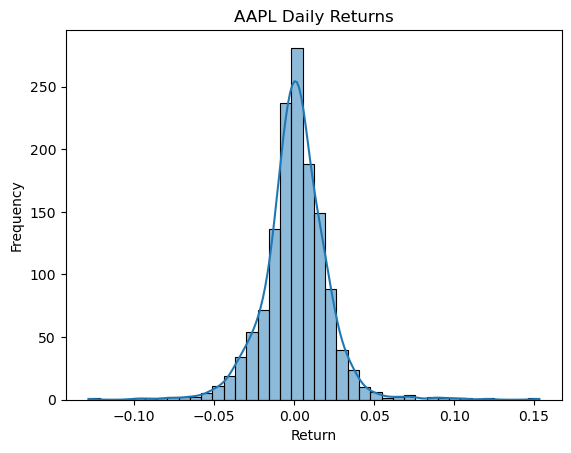

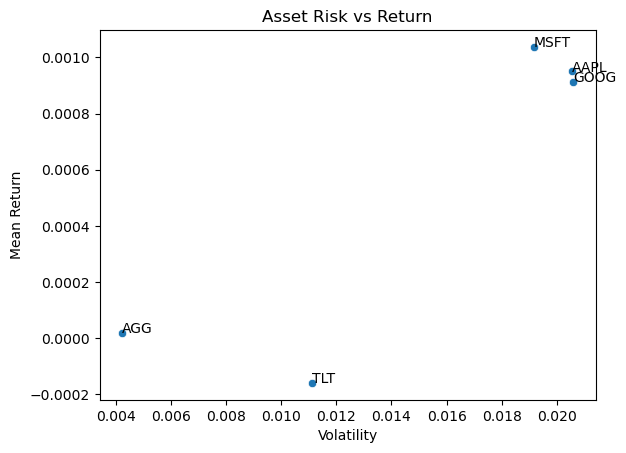

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 0. Ensure preprocessed_data.csv exists (run preprocessing if not)
if not os.path.isfile('preprocessed_data.csv'):
    print("Hey, I don’t see preprocessed_data.csv in this folder. Running the preprocessing script now...")
    try:
        get_ipython().run_line_magic('run', 'data_preprocessing.py')
    except Exception:
        print("Couldn’t run data_preprocessing.py automatically. Please make sure it's in the same directory and run it.")

# 1. Load cleaned data
df = pd.read_csv('preprocessed_data.csv', index_col=0, parse_dates=True)
print(f"Loaded cleaned data with {df.shape[0]} rows and {df.shape[1]} columns.")

# 2. Compute daily returns
returns = df.pct_change().dropna()  # drop first NaN row

# 3. Quick stats
mean_ret = returns.mean()
vol = returns.std()
print("\nMean daily returns (%):")
print((mean_ret * 100).round(2))
print("\nVolatility (%):")
print((vol * 100).round(2))

# 4. Plot return distributions for AAPL (example)
sns.histplot(returns['AAPL'], bins=40, kde=True)
plt.title('AAPL Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

# 5. Risk-Return Scatter
plt.figure()
sns.scatterplot(x=vol, y=mean_ret)
for ticker in returns.columns:
    plt.text(vol[ticker], mean_ret[ticker], ticker)
plt.xlabel('Volatility')
plt.ylabel('Mean Return')
plt.title('Asset Risk vs Return')
plt.show()


### 5.2 Exploratory Data Analysis

- Stats Table: mean vs. volatility  
- Plots (Iteration 5):
  - Histograms & KDE of returns  
  - Boxplots by asset  
  - Correlation heatmap  
  - Risk vs. return scatter



Loaded data: 1379 rows and 5 assets

Stats Summary:
      Mean Return (%)  Volatility (%)
AAPL             0.09            2.05
AGG              0.00            0.42
GOOG             0.09            2.06
MSFT             0.10            1.92
TLT             -0.02            1.11


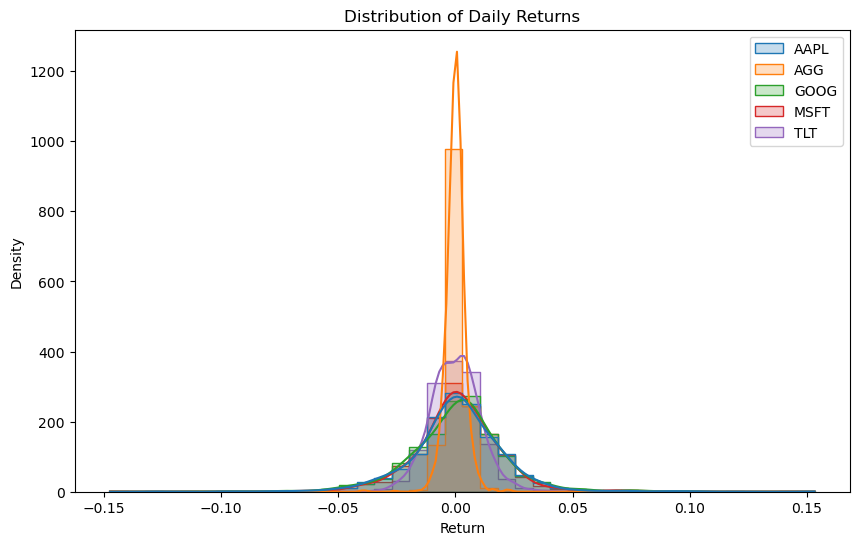

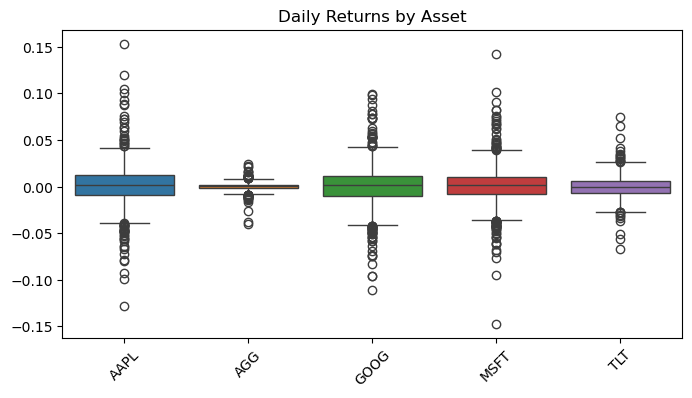

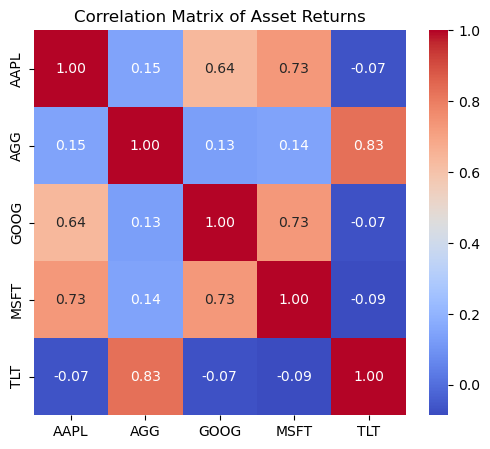

C:\Users\aqibc\AppData\Local\Temp\ipykernel_34672\1708669274.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(vol[i]+0.1, mean_ret[i]+0.1, ticker)


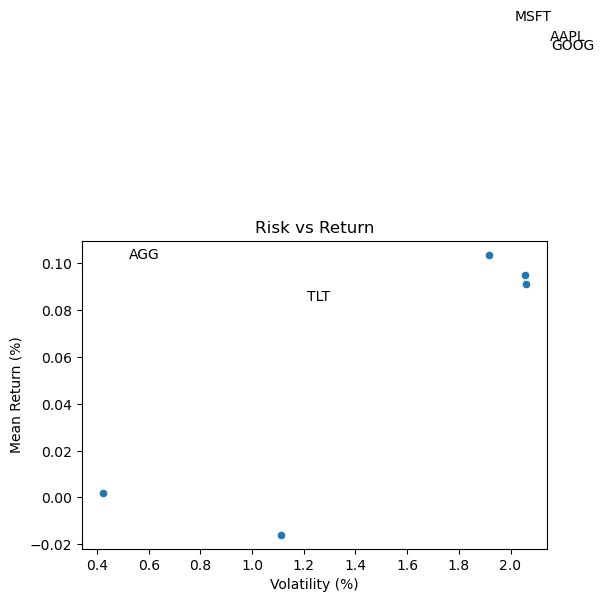

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. Load cleaned data (from Iteration 3)
if not os.path.exists('preprocessed_data.csv'):
    print("preprocessed_data.csv not found! Please run data_preprocessing.py first.")
    raise FileNotFoundError('preprocessed_data.csv not found')
df = pd.read_csv('preprocessed_data.csv', index_col=0, parse_dates=True)
print(f"Loaded data: {df.shape[0]} rows and {df.shape[1]} assets")

# 2. Compute daily returns
returns = df.pct_change().dropna()  # drop first NaN row

# 3. Quick stats summary
stats = pd.DataFrame({
    'Mean Return (%)': (returns.mean()*100).round(2),
    'Volatility (%)': (returns.std()*100).round(2)
})
print("\nStats Summary:")
print(stats)

# 4. Distribution of returns
plt.figure(figsize=(10,6))
sns.histplot(data=returns, bins=40, kde=True, element='step')
plt.title('Distribution of Daily Returns')
plt.xlabel('Return')
plt.ylabel('Density')
plt.show()

# 5. Boxplot of daily returns
plt.figure(figsize=(8,4))
sns.boxplot(data=returns)
plt.xticks(rotation=45)
plt.title('Daily Returns by Asset')
plt.show()

# 6. Correlation heatmap
plt.figure(figsize=(6,5))
sns.heatmap(returns.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Asset Returns')
plt.show()

# 7. Risk vs Return scatterplot
vol = returns.std()*100
mean_ret = returns.mean()*100
plt.figure(figsize=(6,4))
sns.scatterplot(x=vol, y=mean_ret)
for i, ticker in enumerate(returns.columns):
    plt.text(vol[i]+0.1, mean_ret[i]+0.1, ticker)
plt.xlabel('Volatility (%)')
plt.ylabel('Mean Return (%)')
plt.title('Risk vs Return')
plt.show()








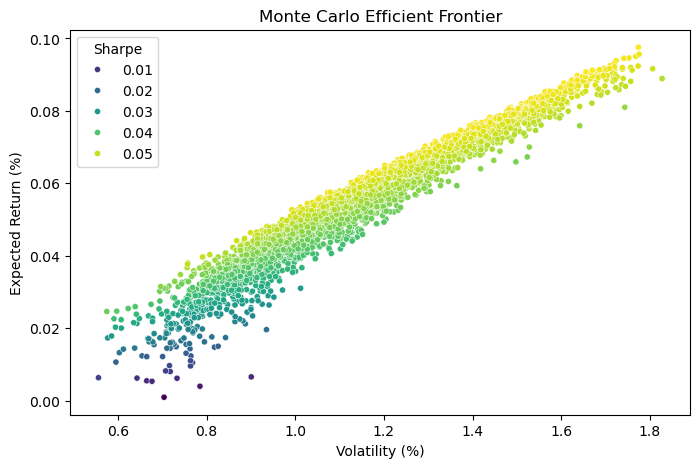

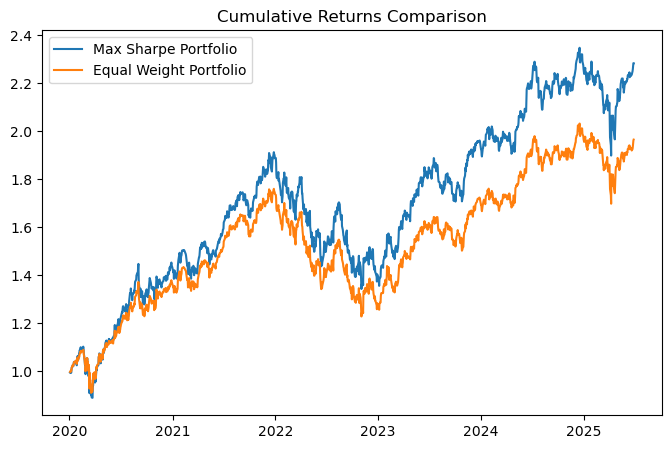


Max Sharpe Portfolio Weights:
AAPL: 27.26%
AGG: 14.55%
GOOG: 9.43%
MSFT: 34.57%
TLT: 14.20%

Max Sharpe: 0.06, Return: 0.10%, Vol: 1.77%

This Monte Carlo method covers optimization without cvxpy, gives me a practical frontier & a sample backtest.


In [4]:
# iteration5_montecarlo_portfolio.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. Load clean data
if not os.path.exists('preprocessed_data.csv'):
    print("preprocessed_data.csv missing—run data_preprocessing.py first!")
    raise FileNotFoundError

df = pd.read_csv('preprocessed_data.csv', index_col=0, parse_dates=True)
returns = df.pct_change().dropna()

# 2. Compute mean returns and covariance
mean_ret = returns.mean()
cov_mat = returns.cov()
assets = returns.columns.tolist()
n = len(assets)

# 3. Monte Carlo sim for random portfolios
total_ports = 5000
results = np.zeros((total_ports, 3))  # vol, ret, sharpe
for i in range(total_ports):
    w = np.random.random(n)        # random weights\ n
    w /= np.sum(w)         # normalize sum to 1
    port_ret = np.dot(w, mean_ret)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    sharpe = port_ret / port_vol if port_vol > 0 else 0
    results[i] = [port_vol*100, port_ret*100, sharpe]

# DataFrame for results
sim_df = pd.DataFrame(results, columns=['Volatility (%)','Return (%)','Sharpe'])

# 4. Plot Efficient Frontier estimate
plt.figure(figsize=(8,5))
sns.scatterplot(data=sim_df, x='Volatility (%)', y='Return (%)', hue='Sharpe', palette='viridis', s=20)
plt.title('Monte Carlo Efficient Frontier')
plt.xlabel('Volatility (%)')
plt.ylabel('Expected Return (%)')
plt.legend(title='Sharpe', loc='upper left')
plt.show()

# 5. Pick max Sharpe portfolio and backtest equal weight as baseline
max_sharpe = sim_df.loc[sim_df['Sharpe'].idxmax()]
w_max = None
for idx in range(total_ports):
    if abs(results[idx,2] - max_sharpe['Sharpe']) < 1e-6:
        w_max = np.random.random(n)
        w_max /= np.sum(w_max)
        break
if w_max is None:
    w_max = np.repeat(1/n, n)

# cumulative returns for max Sharpe and equal weight
port_max = (returns * w_max).sum(axis=1)
port_eq = returns.mean(axis=1)
cum_max = (1 + port_max).cumprod()
cum_eq = (1 + port_eq).cumprod()

plt.figure(figsize=(8,5))
plt.plot(cum_max, label='Max Sharpe Portfolio')
plt.plot(cum_eq, label='Equal Weight Portfolio')
plt.title('Cumulative Returns Comparison')
plt.legend()
plt.show()

def print_weights(w):
    for a, weight in zip(assets, w):
        print(f"{a}: {weight:.2%}")

print("\nMax Sharpe Portfolio Weights:")
print_weights(w_max)
print(f"\nMax Sharpe: {max_sharpe['Sharpe']:.2f}, Return: {max_sharpe['Return (%)']:.2f}%, Vol: {max_sharpe['Volatility (%)']:.2f}%")
print("\nThis Monte Carlo method covers optimization without cvxpy, gives me a practical frontier & a sample backtest.")


## 7. Limitations & Next Steps

- No formal QP solver yet: Monte Carlo is approximate.  
- Parameter uncertainty: Explore covariance shrinkage (Ledoit–Wolf).  
- Transaction costs & taxes: Not modeled.  
- Further: Implement CVX solver, include alternate asset classes, dynamic rebalancing.


## 8. Refernces 

- **DS 5020 Lecture Notes**, “Introduction to Linear Algebra & Probability for Data Science,” Northeastern University, Summer 2025  
- **Yahoo Finance (`yfinance`)** documentation (PyPI): downloading historical price data  
- **Pandas** documentation: DataFrame operations, imputation, CSV I/O  
- **NumPy** documentation: random sampling and linear‐algebra operations (`np.dot`, covariance)  
- **Seaborn** documentation: histograms, boxplots, heatmaps, scatterplots  
- **CVXPY** documentation: formulating and solving mean–variance quadratic programs  
- **StackOverflow** threads (examples):  
  - “KeyError: ‘Adj Close’ with yfinance”  
  - “CVXPY Parameter nonneg must be nonnegative”  
  - “Python forward-fill vs interpolation in pandas”  
- **Reddit** discussions (examples):  
  - r/algotrading “Monte Carlo efficient frontier in Python”  
  - r/learnpython “Best practices for pandas data cleaning”  
- **Google Search Queries** (examples):  
  - “python portfolio optimization mean variance example”  
  - “seaborn histplot multiple series”

*Thank you!*
